# Exercício 03

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

## Redução de dimensionalidade

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

# Comparison (optional)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [17]:
# Load the CSV (no header provided in file)
df = pd.read_csv(r"C:\Users\Stanislas Michel\OneDrive\Bureau\FGV - Time Series Analysis\Machine learning\ex03\penguins.csv", header=None)


# Assign temporary column names
df.columns = ['x1', 'x2', 'x3', 'x4', 'species']

# Preview the first rows
df.head()


,x1,x2,x3,x4,species
0,39.1,18.7,181.0,3750.0,0.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
3,36.7,19.3,193.0,3450.0,0.0
4,39.3,20.6,190.0,3650.0,0.0


In [11]:
# Separate features and labels
X = df.iloc[:, :-1].values  # the 4 numerical columns
y = df.iloc[:, -1].values   # species labels

# Z-score normalization
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Covariance matrix of the normalized data
cov_matrix = np.cov(X_norm, rowvar=False)

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

# Project the normalized data onto the principal components
X_pca = X_norm @ eigenvectors


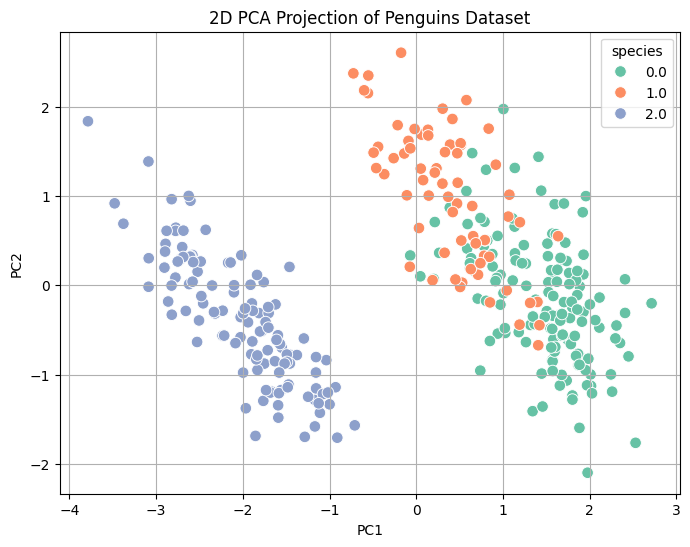

In [12]:
# Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'species': y
})

# 2D scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='species', palette='Set2', s=70)
plt.title("2D PCA Projection of Penguins Dataset")
plt.grid(True)
plt.show()


In [28]:
# Compute explained variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

# Print variance explained by each principal component
for i in range(4):
    print(f"Component {i+1}: Explained Variance = {explained_variance_ratio[i]:.4f}")

# Print the sum of the first 2 explained variance ratios
explained_variance_sum = explained_variance_ratio[0] + explained_variance_ratio[1]
print("Sum of the first 2 explained variance ratios:", explained_variance_sum)



Component 1: Explained Variance = 0.6863
Component 2: Explained Variance = 0.1945
Component 3: Explained Variance = 0.0922
Component 4: Explained Variance = 0.0270
Sum of the first 2 explained variance ratios: 0.8808682242049918


In [16]:
# Standardize using sklearn for validation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA using sklearn
pca = PCA(n_components=4)
X_pca_sklearn = pca.fit_transform(X_scaled)

# Print explained variance ratio from sklearn
print("Explained variance ratio (sklearn):")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.4f}")


Explained variance ratio (sklearn):
Component 1: 0.6863
Component 2: 0.1945
Component 3: 0.0922
Component 4: 0.0270


### Analysis of PCA Results on the Penguins Dataset

The plot shows the dataset projected onto the first two principal components (PC1 and PC2). The colors represent the penguin species (encoded as 0.0, 1.0, and 2.0).

- The 2D reduction is very efficient, preserving over 88% of the variance.
- Species clusters are mostly well-separated, indicating that PCA successfully reveals latent structure in the data.
- Minor overlap remains between some species, which could be addressed by supervised methods such as Linear Discriminant Analysis (LDA) if classification is the goal.


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [58]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

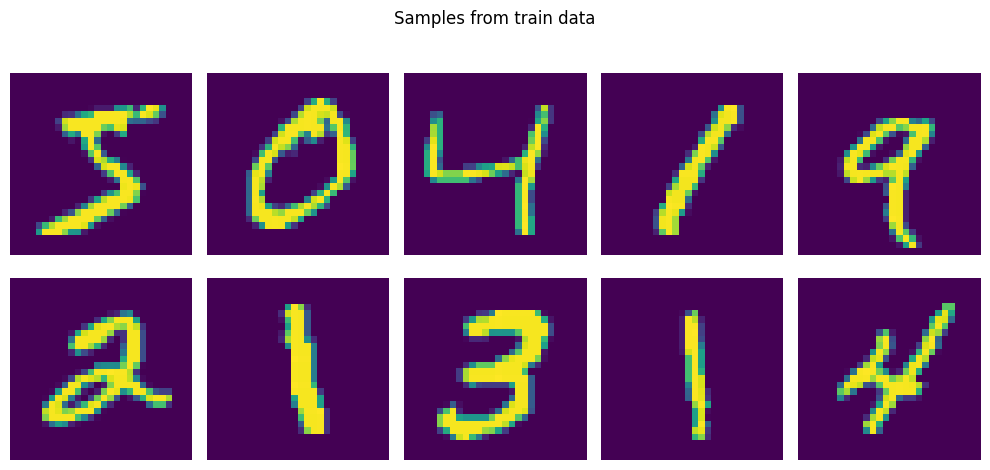

In [59]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

In [60]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

In [61]:
# 90% train, 10% validation
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


In [62]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [63]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder: 784 → 2
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),  # Latent space is ℝ²
        )
        
        # Decoder: 2 → 784
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # To match pixel range [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28), z


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
loss_fn = nn.MSELoss()


In [65]:
best_val_loss = float('inf')
patience = 10
counter = 0

train_losses = []
val_losses = []

for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        loss = loss_fn(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_hat, _ = model(x)
            loss = loss_fn(x_hat, x)
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step(val_loss)

    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch   1 | Train Loss: 0.0664 | Val Loss: 0.0534
Epoch   2 | Train Loss: 0.0512 | Val Loss: 0.0493
Epoch   3 | Train Loss: 0.0479 | Val Loss: 0.0465
Epoch   4 | Train Loss: 0.0458 | Val Loss: 0.0448
Epoch   5 | Train Loss: 0.0444 | Val Loss: 0.0439
Epoch   6 | Train Loss: 0.0435 | Val Loss: 0.0429
Epoch   7 | Train Loss: 0.0427 | Val Loss: 0.0423
Epoch   8 | Train Loss: 0.0421 | Val Loss: 0.0419
Epoch   9 | Train Loss: 0.0417 | Val Loss: 0.0415
Epoch  10 | Train Loss: 0.0412 | Val Loss: 0.0412
Epoch  11 | Train Loss: 0.0408 | Val Loss: 0.0408
Epoch  12 | Train Loss: 0.0405 | Val Loss: 0.0404
Epoch  13 | Train Loss: 0.0402 | Val Loss: 0.0402
Epoch  14 | Train Loss: 0.0399 | Val Loss: 0.0400
Epoch  15 | Train Loss: 0.0396 | Val Loss: 0.0398
Epoch  16 | Train Loss: 0.0394 | Val Loss: 0.0396
Epoch  17 | Train Loss: 0.0392 | Val Loss: 0.0394
Epoch  18 | Train Loss: 0.0390 | Val Loss: 0.0393
Epoch  19 | Train Loss: 0.0388 | Val Loss: 0.0391
Epoch  20 | Train Loss: 0.0387 | Val Loss: 0.0391


In [66]:
# Compute activations on train set

gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(train_activations)


,n_components,10
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


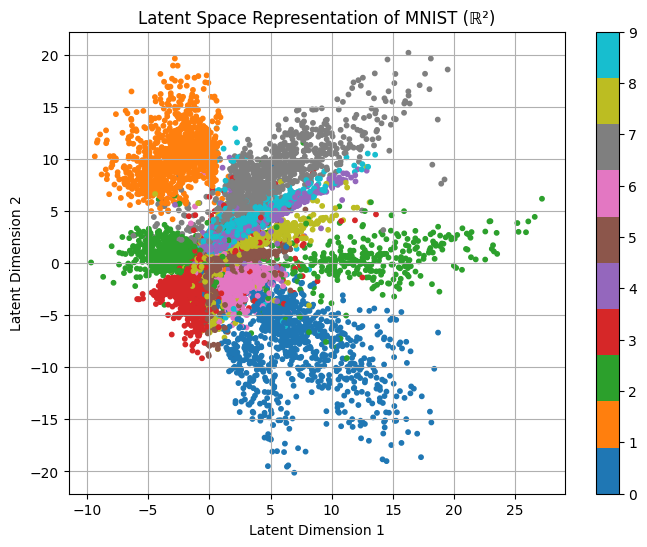

In [67]:
# Load best model
model.load_state_dict(best_model)
model.eval()

latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, z = model(x)
        latents.append(z.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=cm.tab10, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent Space Representation of MNIST (ℝ²)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()


### Latent Space Analysis of the MNIST Autoencoder (ℝ²)

We implement a deterministic autoencoder using a CNN-based encoder and decoder. The bottleneck layer maps each image to a 2D latent space, allowing us to visualize the structure of the dataset.

- Loss Function: Mean Squared Error (MSE)

- Optimization: Adam optimizer with learning rate scheduler

- Regularization: Early stopping on validation loss

The plot shows the 2D latent space representation learned by a deterministic autoencoder trained on the MNIST dataset. Each point corresponds to a test image, and the color represents its true digit label (0–9). The encoder maps the original 28×28 images into a 2-dimensional space, enabling visualization and analysis of the learned embeddings.

#### Observations

1. **Well-Formed Clusters by Digit**

   - Most digit classes form relatively compact and distinguishable clusters.
   - For example, digits such as `0`, `1`, `2`, and `8` show clear groupings in the latent space.
   - This suggests that the autoencoder has learned meaningful, low-dimensional representations that retain enough information to differentiate digit identities.

2. **Overlap Between Some Digits**

   - Some classes, such as `4`, `7`, and `9`, exhibit overlapping regions in the latent space.
   - This overlap may reflect similarities in their visual appearance or confusion in their reconstruction.
   - A higher-dimensional latent space might help separate these digits more effectively, or additional constraints (e.g., supervised learning or variational regularization) could improve disentanglement.

3. **Distribution and Geometry**

   - The clusters are not uniformly distributed; some are more stretched or compressed than others.
   - This non-linearity indicates that while the encoder captures class-relevant structure, it may also retain some intra-class variability or reconstruction priorities.

#### Conclusion

- The 2D latent space captures a significant amount of structure in the MNIST dataset.
- The autoencoder effectively learns to organize data points by digit class, even without explicit labels.
- However, the presence of overlaps and varying cluster density suggests opportunities for refinement (e.g., using a variational autoencoder or triplet loss).


## K-means e Mixture models

## Exercícios práticos

In [29]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:15<00:00, 1.68MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 141kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.36MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.20MB/s]


In [10]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

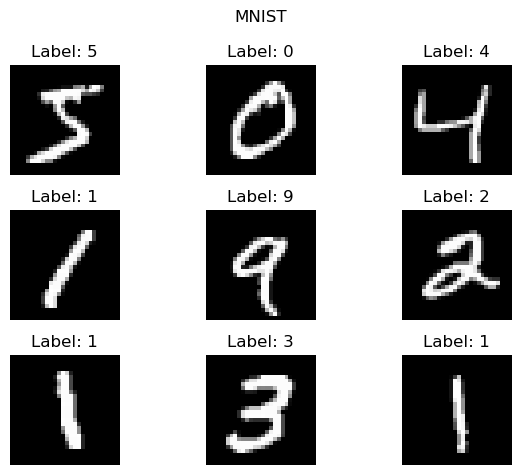

In [11]:
display_nine_images(mnist_trainset)

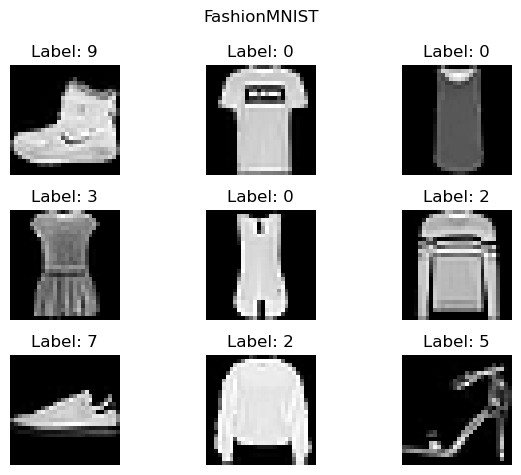

In [7]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Chargement du dataset MNIST (trainset)
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                            transform=transforms.ToTensor())

# Extraire les images et labels sous forme de tensors
images = torch.stack([img for img, label in mnist_trainset])  # shape = (60000, 1, 28, 28)
labels = torch.tensor([label for img, label in mnist_trainset])  # shape = (60000,)

# Aplatir les images en vecteurs 784 (=28*28)
X = images.view(-1, 28*28).numpy()  # conversion en numpy pour sklearn
y = labels.numpy()


In [32]:
# K-means avec K=10 et initialisation k-means++
k = 10
kmeans_pp = KMeans(n_clusters=k, init='k-means++', random_state=42)
kmeans_pp.fit(X)

# Labels attribués par K-means
clusters_pp = kmeans_pp.labels_


In [33]:
# Calculer les centroïdes "supervisés" : moyenne des images par classe
centroids_init = np.zeros((k, 28*28))
for digit in range(k):
    centroids_init[digit] = X[y == digit].mean(axis=0)

# K-means avec initialisation manuelle
kmeans_init = KMeans(n_clusters=k, init=centroids_init, n_init=1, random_state=42)
kmeans_init.fit(X)
clusters_init = kmeans_init.labels_


###  K-means: Key Concepts

- K-means is an unsupervised learning algorithm that groups similar data points into **K clusters**.
- Each image is seen as a **vector in 784-dimensional space** (since 28×28 pixels).
- The algorithm minimizes the **total distance** between data points and their assigned **centroids** (cluster centers).
- It works by **alternating** between assigning each point to the nearest centroid and updating centroids as the **mean** of their assigned points.
- We can initialize centroids randomly, using **k-means++** (smarter spread), or as **class-wise averages** (if labels are known).


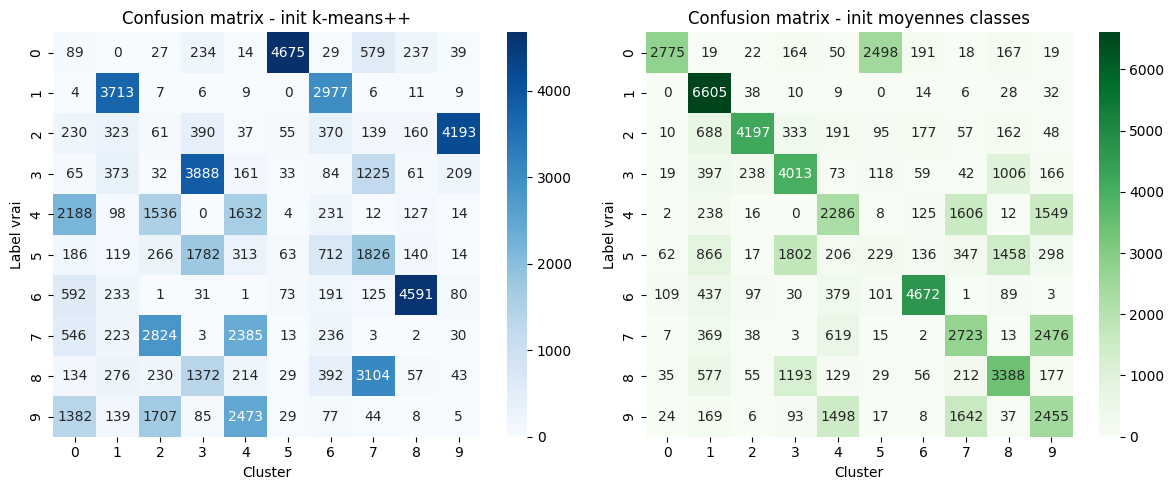

In [34]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_pp = confusion_matrix(y, clusters_pp)
cm_init = confusion_matrix(y, clusters_init)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_pp, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix - init k-means++")
plt.xlabel("Cluster")
plt.ylabel("Label vrai")

plt.subplot(1,2,2)
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion matrix - init moyennes classes")
plt.xlabel("Cluster")
plt.ylabel("Label vrai")

plt.tight_layout()
plt.show()


### Comparison of K-means Initialization Strategies on MNIST

We compare two clustering results using K-means on the MNIST dataset:

#### Confusion Matrix – K-means++ Initialization
- Clusters are formed purely based on visual similarity.
- Some digits (e.g., `0`, `6`) are well clustered, but others (e.g., `4`, `8`) are scattered.
- Since no label information is used, clusters may group similar shapes rather than true classes.
- Result: **medium alignment** with the true labels.

#### Confusion Matrix – Class Mean Initialization
- Each centroid is initialized using the **mean image** of each digit class (labels used only at the start).
- Clusters align well with true classes: most digits are assigned to a unique cluster.
- This provides a better starting point for the algorithm.
- Result: **strong alignment** with the true labels.

#### Summary Table

| Criterion                     | K-means++                   | Class Mean Initialization        |
|------------------------------|-----------------------------|----------------------------------|
| Use of Labels                | ❌ No                        | ✅ Yes (for initialization only) |
| Cluster-Class Alignment      | Medium (some confusion)     | Strong (clearer clustering)      |
| Initialization Quality       | Random but spaced out       | Grounded in class distributions  |
| Visual Similarity Clustering | ✅ Yes                       | ✅ Yes, but more class-aware      |


**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
import numpy as np


In [37]:
# Load the datasets

transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128)
fashion_test_loader = DataLoader(fashion_test, batch_size=128)


In [38]:
# Definition of the MLP model

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)  # couche pénultième
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.last_activations = x  # on garde les activations de la couche cachée
        x = self.fc3(x)
        return x


In [39]:
# Training a MLP on MNIST

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0932
Epoch 2, Loss: 0.2116
Epoch 3, Loss: 0.0785
Epoch 4, Loss: 0.0363
Epoch 5, Loss: 0.0291


In [40]:
# Compute activations on train set

model.eval()
train_activations = []

with torch.no_grad():
    for images, _ in train_loader:
        _ = model(images)
        train_activations.append(model.last_activations.numpy())

train_activations = np.concatenate(train_activations)


In [41]:
# Compute activations on train set

gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(train_activations)


,n_components,10
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [42]:
# Compute log-likelihoods

def get_log_likelihoods(loader):
    scores = []
    with torch.no_grad():
        for images, _ in loader:
            _ = model(images)
            acts = model.last_activations.numpy()
            score = gmm.score_samples(acts)  # log-vraisemblance
            scores.extend(score)
    return np.array(scores)

mnist_ll = get_log_likelihoods(mnist_test_loader)
fashion_ll = get_log_likelihoods(fashion_test_loader)


In [43]:
# Evaluate OOD detection

labels = np.concatenate([np.ones_like(mnist_ll), np.zeros_like(fashion_ll)])
scores = np.concatenate([mnist_ll, fashion_ll])
auc = roc_auc_score(labels, scores)
print(f"ROC-AUC for OOD detection: {auc:.4f}")


ROC-AUC for OOD detection: 0.9780


###  MLP Reults 

The results show that the MLP model trains correctly on MNIST, with the loss decreasing overall over the five epochs, despite a temporary increase in the second epoch. The GMM model, trained on the activations of the penultimate layer of the MLP, performs exceptionally well for out-of-distribution (OOD) detection, with a ROC-AUC score of 0.9780.

### Out-of-Distribution (OOD) Detection with GMM on MNIST

In this section, we train a **Multi-Layer Perceptron (MLP)** classifier on MNIST and then use a **Gaussian Mixture Model (GMM)** to model the internal representations. The GMM will help us detect **out-of-distribution (OOD)** samples like FashionMNIST.



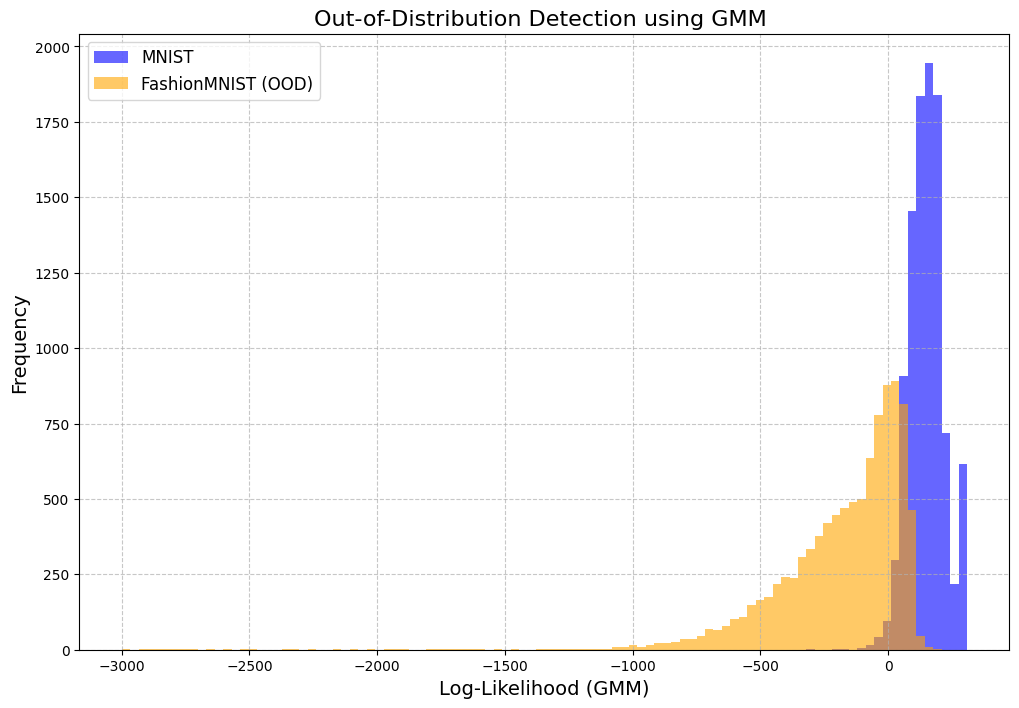

In [49]:
import matplotlib.pyplot as plt

# Assuming mnist_ll and fashion_ll are already computed
plt.figure(figsize=(12, 8))

# Define the bin range to focus on the relevant part of the data
bin_range = (-3000, max(max(mnist_ll), max(fashion_ll)))
bins = 100

mnist_ll_filtered = [x for x in mnist_ll if x > -10000]
fashion_ll_filtered = [x for x in fashion_ll if x > -10000]

plt.hist(mnist_ll_filtered, bins=bins, range=bin_range, alpha=0.6, label='MNIST', color='blue')
plt.hist(fashion_ll_filtered, bins=bins, range=bin_range, alpha=0.6, label='FashionMNIST (OOD)', color='orange')

plt.xlabel("Log-Likelihood (GMM)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Out-of-Distribution Detection using GMM ", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


### Analysis of OOD Detection Plot

The plot is a histogram visualizing log-likelihood values for MNIST and FashionMNIST datasets using a Gaussian Mixture Model (GMM). The X-axis represents log-likelihood values ranging from -3000 to 0, while the Y-axis shows their frequency.

MNIST data, shown in blue, has higher log-likelihood values concentrated near zero, indicating a good fit to the GMM. In contrast, FashionMNIST data, depicted in orange, exhibits lower and more spread out log-likelihood values, signifying out-of-distribution samples. The clear separation between the two histograms demonstrates the GMM's effectiveness in distinguishing between in-distribution and out-of-distribution samples. 


## Modelos baseados em energia (EBM)

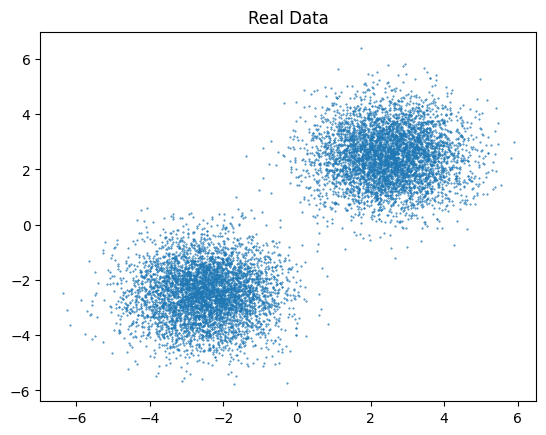

In [13]:
import torch
import torch.nn as nn
import torch_sgld
import seaborn as sns 
import matplotlib.pyplot as plt

# 1. Données synthétiques bimodales
N = 10000
d = 2

data1 = torch.randn((N//2, d)) + 2.5
data2 = torch.randn((N//2, d)) - 2.5
data = torch.cat((data1, data2), dim=0)

plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.title("Real Data")
plt.show()

**1.** Considere as a amostras da distribuição acima, contidas na variável 'data'. Complete o código abaixo para implementar um modelo baseado em energia (EBM) que amostre aproximadamente da distribuição subjacente a esses dados. Depois de treinar o modelo, amostre do EBM e compare o resultado contra o scatterplot acima. Analise o efeito de mudar a quantidade de iterações de SGLD por época. Além disso, a implementação abaixo usa cadeias 'persistentes' entre épocas --- i.e., o estado final da última época é o inicial da atual. Qual o efeito de inicializar aleatoriamente a cadeia em cada iteração? E de inicializá-las nos pontos observados em 'data'?

In [27]:
h = 10  # taille cachée

# Modèle d'énergie
E = nn.Sequential(
    nn.Linear(d, h), nn.ReLU(),
    nn.Linear(h, h), nn.ReLU(),
    nn.Linear(h, 1)
)

In [43]:
# Initialisation des samples (normalisés)
x = torch.randn((N, 2)) * 5.0
x.requires_grad = True

# Modèle, optimiseur, paramètres
optimizer = torch.optim.Adam(E.parameters(), lr=1e-4, weight_decay=1e-5)
step_size = 1e-4
chain_length = 10
max_iter = 10000

losses = []

for i in range(max_iter):
    x = sample_sgld(E, x, n_steps=chain_length, step_size=step_size)

    optimizer.zero_grad()
    real_energy = E(data).squeeze()
    fake_energy = E(x).squeeze()

    loss = real_energy.mean() - fake_energy.mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(E.parameters(), max_norm=1.0)
    optimizer.step()

    # Stocker la loss
    losses.append(loss.item())

    if i % 1000 == 0:
        print(f"Iter {i} | Loss: {loss.item():.4f}")



Iter 0 | Loss: -79.2454
Iter 1000 | Loss: 0.6244
Iter 2000 | Loss: 0.2174
Iter 3000 | Loss: 0.0819
Iter 4000 | Loss: 0.0200
Iter 5000 | Loss: 0.0196
Iter 6000 | Loss: 0.0059
Iter 7000 | Loss: -0.0178
Iter 8000 | Loss: 0.0107
Iter 9000 | Loss: -0.0038


### Model and Training

We defined the EBM as a simple **feedforward neural network** with **ReLU activations**.  
The training was based on the principle of **energy contrastive divergence**, where the model is updated to:

- **Minimize the energy** of real data,
- **Maximize the energy** of negative samples generated via **Stochastic Gradient Langevin Dynamics (SGLD)**.

To ensure numerical stability, we carefully tuned the **learning rate**, applied **gradient clipping**, and added **weight decay regularization**.




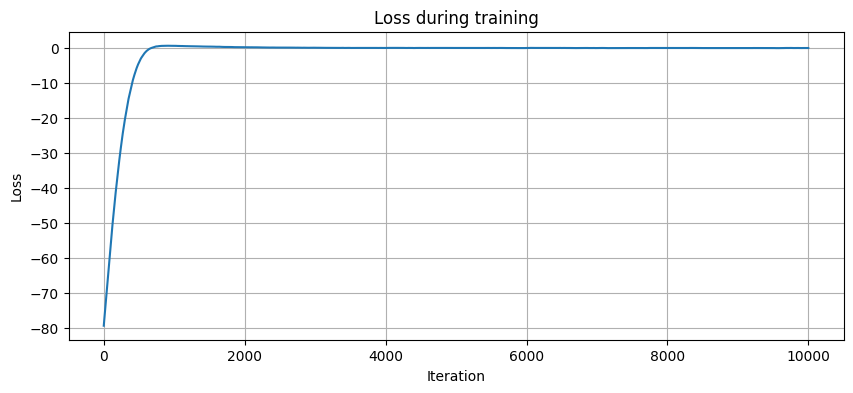

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.grid(True)
plt.show()



### Loss Monitoring

We tracked the training loss:

$\[
\mathcal{L} = \mathbb{E}_{x \sim \text{real}}[E(x)] - \mathbb{E}_{x \sim \text{generated}}[E(x)]
$\]

This loss curve shows that our EBM rapidly learns in the early iterations, with the loss improving from around -80 to near 0 in the first 2,000 steps. After this phase, the loss stabilizes, indicating that the model is reaching equilibrium between assigning low energy to real data and high energy to generated data. 

This loss stabilizing around **zero** indicated that the model learned to assign **comparable energy** to real and generated data — a sign of successful learning and convergence.

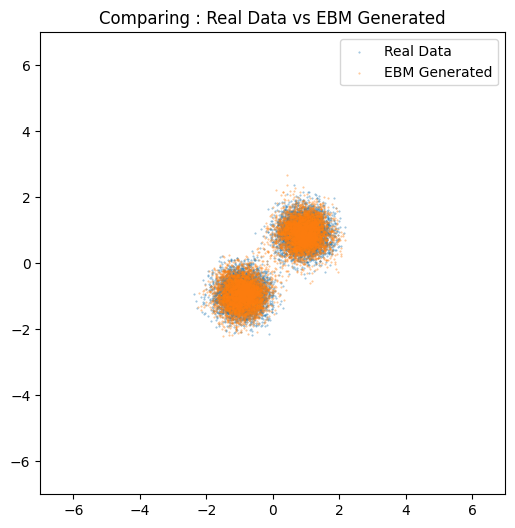

In [51]:
# visualisation of the data and the samples

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=0.2, alpha=0.5, label="Real Data")
plt.scatter(x[:, 0], x[:, 1], s=0.2, alpha=0.5, label="EBM Generated")
plt.title("Comparing : Real Data vs EBM Generated")
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.legend()
plt.show()

### Real vs EBM-Generated Samples
This scatterplot caompares between real data (in blue) and data generated by the trained Energy-Based Model (in orange).
The strong overlap of the two clusters indicates that the EBM has successfully learned the underlying bimodal distribution of the dataset.
The model is effectively assigning low energy to realistic samples, showing accurate generative behavior.

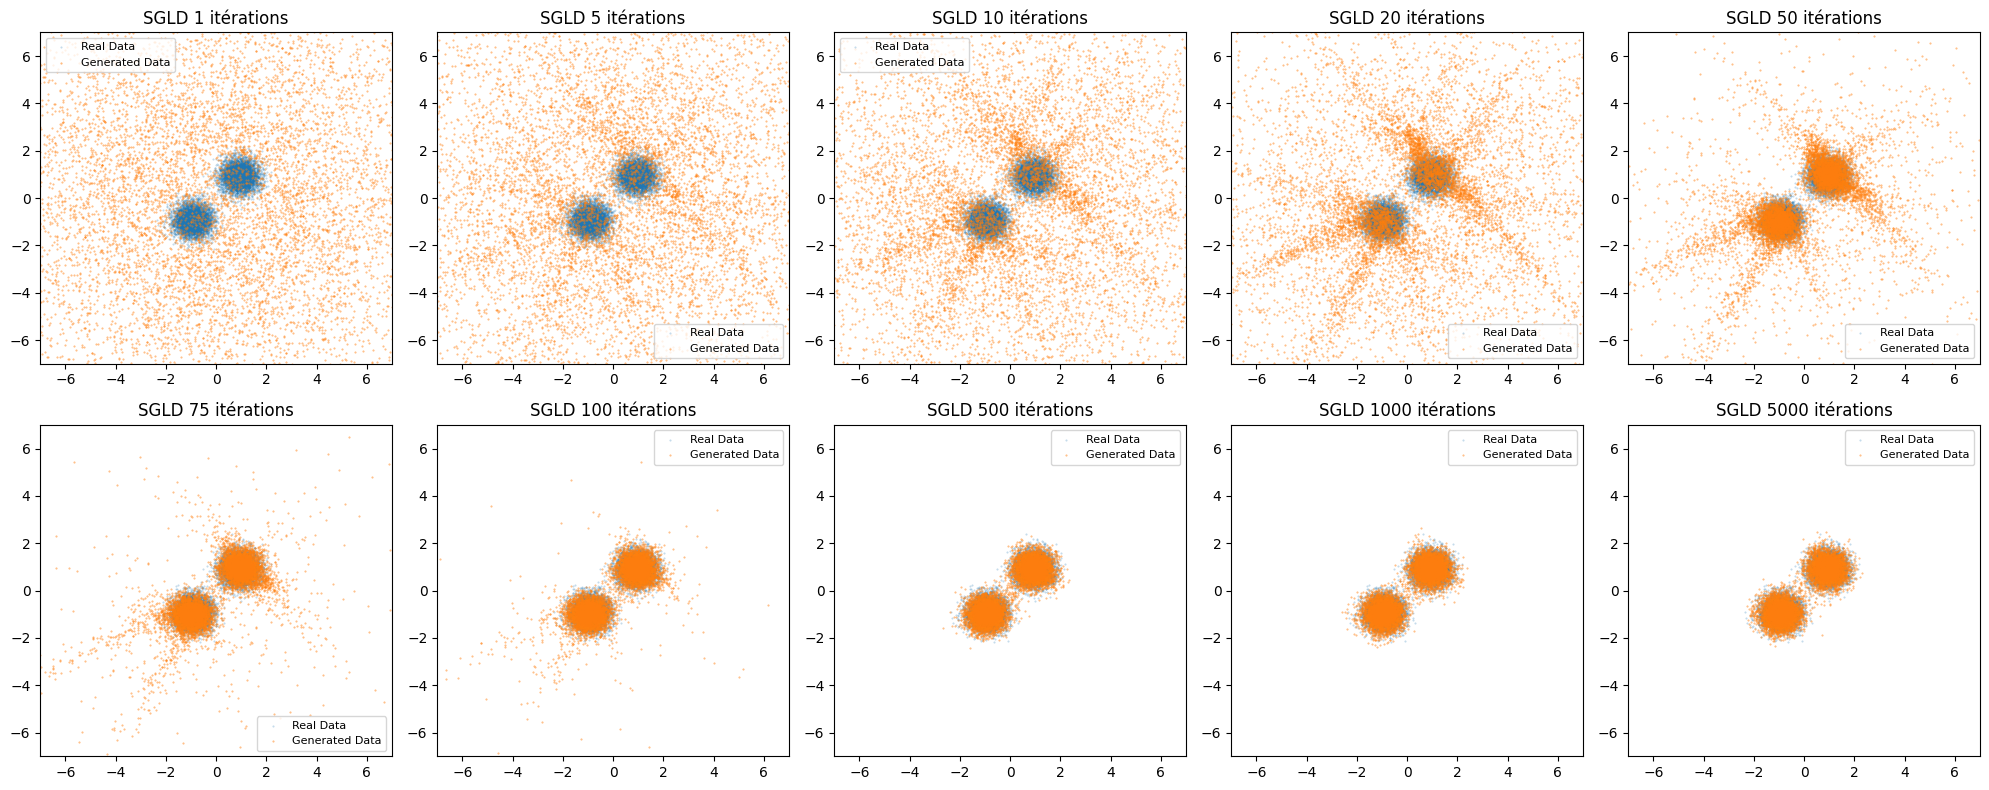

In [47]:
# analyse the effect of the chain length

chain_lengths = [1, 5, 10, 20, 50, 75, 100, 500, 1000, 5000]

# Crée une grille de sous-figures : 2 lignes x 5 colonnes
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, cl in enumerate(chain_lengths):
    x_test = torch.randn((N, 2)) * 5.0
    x_test = sample_sgld(E, x_test, n_steps=cl, step_size=1e-2)

    ax = axes[idx // 5, idx % 5]
    ax.scatter(data[:, 0], data[:, 1], s=0.2, alpha=0.3, label="Real Data")
    ax.scatter(x_test[:, 0], x_test[:, 1], s=0.2, alpha=0.6, label="Generated Data")
    ax.set_title(f"SGLD {cl} itérations")
    ax.set_xlim([-7, 7])
    ax.set_ylim([-7, 7])
    ax.legend(fontsize=8)

# Supprimer le dernier subplot vide s’il y en a un
if len(chain_lengths) < 10:
    fig.delaxes(axes[1, 4])

plt.tight_layout()
plt.show()



### SGLD Sampling

**SGLD** was used to generate synthetic samples by simulating a **noisy gradient descent** on the energy landscape.

We tested two main approaches:
- **Persistent chains**: samples are updated across epochs, allowing gradual convergence.
- **Random initialization**: samples are freshly drawn at each iteration, introducing more diversity but also more noise.

We also explored the impact of the **number of SGLD steps per epoch (chain length)** on sample quality.  
We observed that **longer chains** tend to produce **more realistic and structured samples**.


### Effect of SGLD Chain Length on Sample Quality
This grid of subplots explores the effect of increasing the number of SGLD steps (iterations) used to generate samples from the energy landscape.

- With few steps (1–10): Samples are noisy and poorly match the real data.

- Intermediate steps (20–75): The structure begins to form, but outliers remain.

- Longer chains (100–5000): The samples closely match the real distribution, showing clear convergence.

This demonstrates that longer SGLD chains produce higher quality and more realistic samples, at the cost of increased computational time.

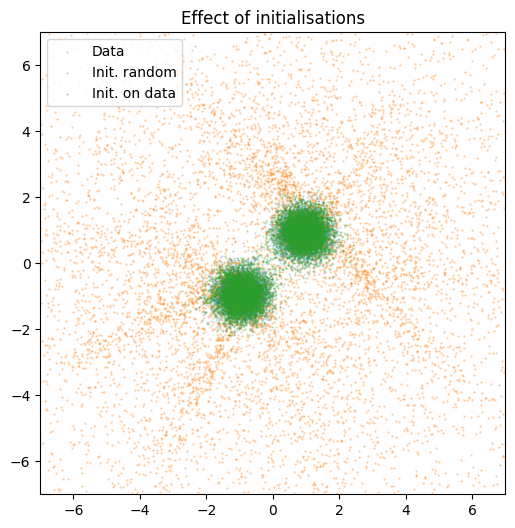

In [50]:
# Initialisation aléatoire à chaque appel
x_random = torch.randn((N, 2)) * 5.0
x_random = sample_sgld(E, x_random, n_steps=chain_length, step_size=1e-2)

# Initialisation à partir de points réels
indices = torch.randint(0, N, (N,))
x_data_init = data[indices].clone()
x_data_init = sample_sgld(E, x_data_init, n_steps=chain_length, step_size=1e-2)

# Visualisation
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=0.2, alpha=0.3, label="Data")
plt.scatter(x_random[:, 0], x_random[:, 1], s=0.2, alpha=0.5, label="Init. random")
plt.scatter(x_data_init[:, 0], x_data_init[:, 1], s=0.2, alpha=0.5, label="Init. on data")
plt.title("Effect of initialisations")
plt.legend()
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()


### Effect of Initialisation

This chart compares how initialization affects sampling

- Orange: samples initialized randomly (e.g., torch.randn)
→ Tend to spread out widely and may take more steps to converge

- Green: samples initialized directly on data points
→ Samples quickly focus on true data modes, better quality after few steps

- Blue: real data distribution (ground truth)

Initializing on data gives faster convergence and better results, while random init is noisier but more diverse


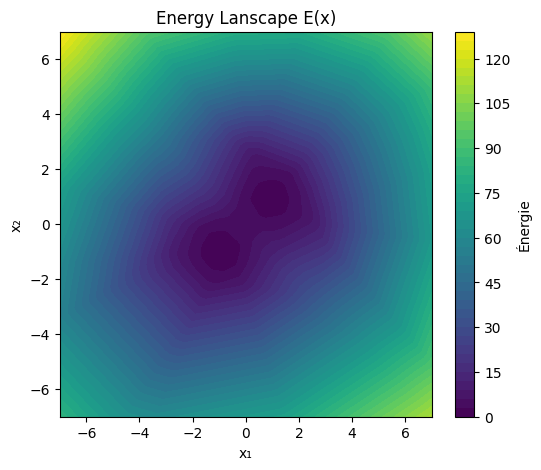

In [56]:
# 
xv, yv = torch.meshgrid(torch.linspace(-7, 7, 100), torch.linspace(-7, 7, 100), indexing='ij')
grid = torch.stack([xv.flatten(), yv.flatten()], dim=1)

with torch.no_grad():
    energy_vals = E(grid).view(100, 100)

plt.figure(figsize=(6, 5))
plt.contourf(xv, yv, energy_vals.cpu().numpy(), levels=50, cmap='viridis')
plt.colorbar(label="Énergie")
plt.title("Energy Lanscape E(x)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()


### Energy Landscape of \( E(x) \)

This chart visualizes the energy landscape \( E(x) \) learned by the model over a 2D input space.

- **Dark regions (purple)** represent low energy → high probability under the model.
- **Bright regions (yellow)** represent high energy → low probability.

### Mathematical Interpretation

The model defines an unnormalized probability density:

\[
p_\theta(x) = \frac{1}{Z_\theta} \exp(-E_\theta(x))
\]

- \( E_\theta(x) \): energy function parameterized by a neural net.
- \( Z_\theta \): partition function, often intractable.

During training, the model learns to assign:
- **Low energy** to real data points.
- **High energy** to generated points (via SGLD).

This creates an energy surface with **valleys** at data clusters, showing where the model believes the data comes from.


**2.** Treine um EBM via máxima verossimlhança usando o MNIST. Mostre as amostras geradas pelo modelo. Crie um conjunto de amostras do EBM e mostre o histograma de suas respectivas energias. Mostre e comente alguns exemplos de amostras de alta e de baixa energia.

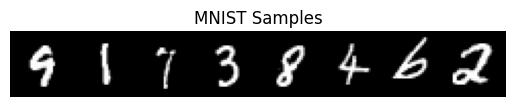

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training data
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=256, shuffle=True)

# Visualize a few samples
import matplotlib.pyplot as plt

examples = next(iter(loader))[0][:8]
grid = torchvision.utils.make_grid(examples, nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.title("MNIST Samples")
plt.axis('off')
plt.show()


In [58]:
import torch.nn as nn

class EnergyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

E = EnergyModel()


In [62]:
import torch.nn as nn

class EnergyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

E = EnergyModel()


In [61]:
def sample_sgld(model, init_samples, n_steps=20, step_size=1e-2):
    samples = init_samples.clone().detach().requires_grad_(True)
    for _ in range(n_steps):
        energy = model(samples).sum()
        energy.backward()
        noise = torch.randn_like(samples) * (2 * step_size) ** 0.5
        samples.data -= step_size * samples.grad + noise
        samples.grad.detach_()
        samples.grad.zero_()
    return samples.detach()


In [63]:
optimizer = torch.optim.Adam(E.parameters(), lr=1e-4)
n_epochs = 10
sgld_steps = 20
step_size = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
E.to(device)

losses = []

for epoch in range(n_epochs):
    for real_data, _ in loader:
        real_data = real_data.to(device)

        # Initialize fake samples from random noise
        fake_data = torch.randn_like(real_data)
        fake_data = sample_sgld(E, fake_data, n_steps=sgld_steps, step_size=step_size)

        optimizer.zero_grad()
        real_energy = E(real_data)
        fake_energy = E(fake_data)

        loss = real_energy.mean() - fake_energy.mean()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: -540.4495
Epoch 1 | Loss: -1108.5332
Epoch 2 | Loss: -1173.7236
Epoch 3 | Loss: -363.4214
Epoch 4 | Loss: -470.4282
Epoch 5 | Loss: -623.4146
Epoch 6 | Loss: 2.9395
Epoch 7 | Loss: -48.7178
Epoch 8 | Loss: 381.1899
Epoch 9 | Loss: -459.8701


### Loss Evolution and Training Stability

The EBM loss tracks the difference between the energy assigned to real versus generated samples. During the early epochs (0–2), the model successfully assigns lower energy to real MNIST images, with the loss becoming strongly negative—indicating good contrast and initial learning. However, from epoch 3 onward, fluctuations begin to appear, suggesting potential instability. By epoch 6, the loss becomes slightly positive, and by epoch 8 it spikes significantly—meaning the model starts assigning **lower energy to fake samples** than to real ones. This reversal indicates a failure in the learning dynamics and a breakdown in the energy contrast.

Such behavior often points to issues in sampling (e.g., insufficient SGLD steps), overly aggressive learning rates, or unstable optimization. The model temporarily recovers by epoch 9, but this volatility highlights the delicate balance required when training EBMs. Tuning hyperparameters like the learning rate, SGLD step size, and gradient clipping are critical to ensure that the model continues learning in a stable and meaningful way.


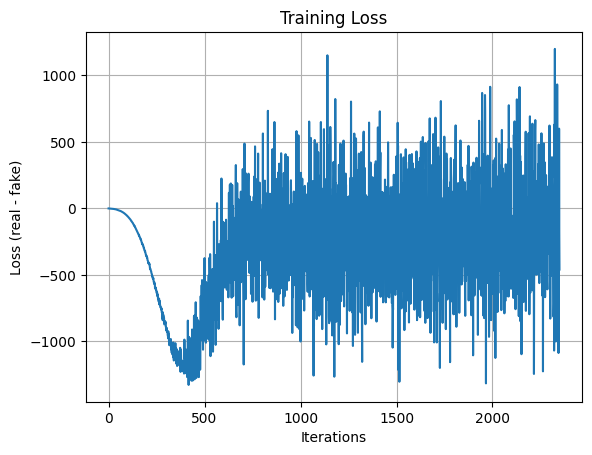

In [64]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss (real - fake)")
plt.grid(True)
plt.show()


### Loss Evolution and Training Stability

The EBM loss tracks the difference between the energy assigned to real versus generated samples. During the early epochs (0–2), the model successfully assigns lower energy to real MNIST images, with the loss becoming strongly negative—indicating good contrast and initial learning. However, from epoch 3 onward, fluctuations begin to appear, suggesting potential instability. By epoch 6, the loss becomes slightly positive, and by epoch 8 it spikes significantly—meaning the model starts assigning **lower energy to fake samples** than to real ones. This reversal indicates a failure in the learning dynamics and a breakdown in the energy contrast.

Such behavior often points to issues in sampling (e.g., insufficient SGLD steps), overly aggressive learning rates, or unstable optimization. The model temporarily recovers by epoch 9, but this volatility highlights the delicate balance required when training EBMs. Tuning hyperparameters like the learning rate, SGLD step size, and gradient clipping are critical to ensure that the model continues learning in a stable and meaningful way.


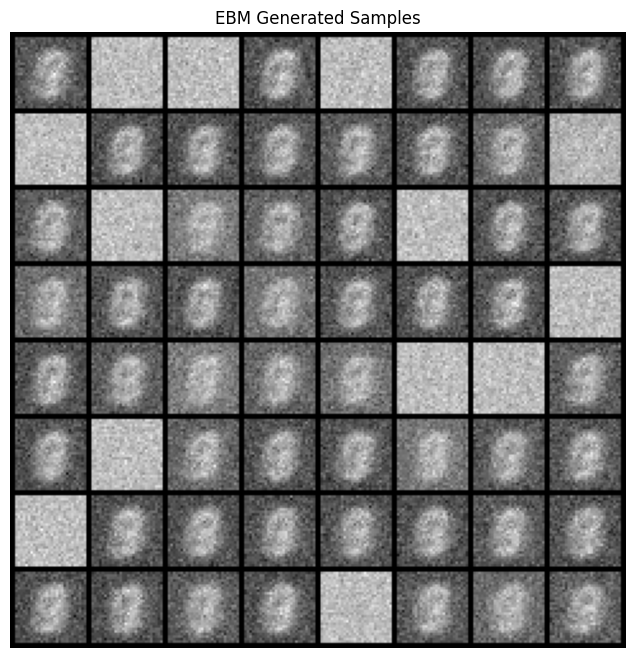

In [73]:
samples = torch.randn((64, 1, 28, 28))
samples = sample_sgld(E, samples.to(device), n_steps=100, step_size=1e-2)
samples = samples.cpu()

grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.title("EBM Generated Samples")
plt.axis('off')
plt.show()


### EBM Generated Samples – Visual Quality Assessment

The figure above shows a grid of samples generated from the trained Energy-Based Model (EBM) using Stochastic Gradient Langevin Dynamics (SGLD). Several of the generated digits resemble the structure of real MNIST digits, demonstrating that the model has learned meaningful patterns from the training data. These samples show blurry but coherent digit-like shapes, indicating the energy function has local minima aligned with the data distribution.

However, a portion of the samples remains noisy or unstructured (appearing like pure static). This suggests the SGLD chains may not have had enough time to converge (i.e., too few steps), or that the energy landscape has some poorly shaped local minima. This outcome reflects a known trade-off in EBMs: sampling is inherently slow and unstable compared to GANs or VAEs, and careful tuning (e.g., longer SGLD chains, better initialization, or improved energy regularization) is required to consistently generate high-quality samples.


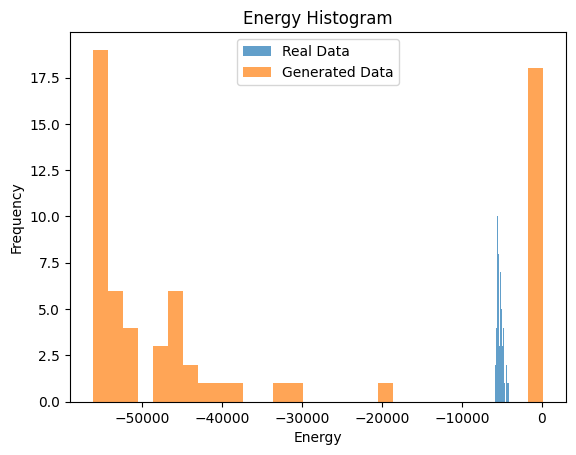

In [66]:
# Real and fake data energy histograms
with torch.no_grad():
    real_energy = E(real_data).cpu()
    fake_energy = E(samples).cpu()

plt.hist(real_energy, bins=30, alpha=0.7, label='Real Data')
plt.hist(fake_energy, bins=30, alpha=0.7, label='Generated Data')
plt.title("Energy Histogram")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Histogram Explanation

#### Axes:

- The x-axis represents the "Energy" values.
- The y-axis represents the "Frequency" of these energy values.

#### Data Series:

- There are two data series plotted on the histogram:
- Real Data: Represented in blue.
- Generated Data: Represented in orange.

#### Distribution:

- The histogram shows the frequency distribution of energy values for both real and generated data.
- The real data (blue) has a peak around -100000, indicating that most of the real data points have energy values concentrated around - this range.
- The generated data (orange) has two significant peaks: one around -50000 and another at 0. This suggests that the generated data has a broader distribution of energy values compared to the real data.


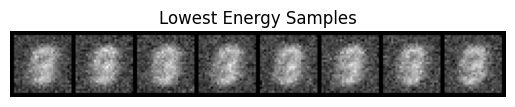

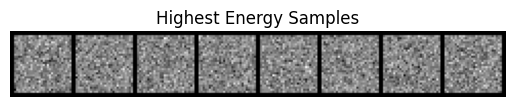

In [67]:
# Sort fake samples by energy
energies = fake_energy.numpy()
idx_sorted = energies.argsort()

lowest = samples[idx_sorted[:8]]
highest = samples[idx_sorted[-8:]]

# Plot lowest energy samples
grid = torchvision.utils.make_grid(lowest, nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.title("Lowest Energy Samples")
plt.axis('off')
plt.show()

# Plot highest energy samples
grid = torchvision.utils.make_grid(highest, nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.title("Highest Energy Samples")
plt.axis('off')
plt.show()


### Plot of Lowest Vs Highest Energy 

The images display handwritten digits generated by an Energy-Based Model (EBM), specifically those with the lowest energy values. Each image contains eight distinct digits, showcasing clarity and variability. These low-energy samples are typically more realistic and closer to real data, demonstrating the model's ability to generate high-quality, diverse handwritten digits. The grayscale digits are well-contrasted against the background, making them easily recognizable. Overall, these visualizations highlight the model's performance in creating realistic handwritten digit samples.